In [1]:
from typing import Dict, Union
from langgraph.graph import StateGraph
from langchain.agents import AgentExecutor, Tool
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
import base64
from typing_extensions import Annotated, List, TypedDict, Dict, Any, Literal
from typing import Optional
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain.prompts.chat import ChatPromptTemplate



In [2]:
class State(TypedDict):
    """Simple state object."""
    image_path:Optional[str]
    input_type: str
    content : str
    result:str
    

In [3]:

messages = SystemMessage(content="You are a helpful assistant tasked with helping users with their shopping experience. You should reply to the users messages with questions how can you help them and what products can you find for them")



In [4]:
def determine_input_type(state: State) -> Dict:
    if isinstance(state['content'], bytes):
        return {"input_type": "image"}
    else:
        return {"input_type": "text"}
    

In [5]:
def router(d:Dict)-> Literal["handle_text", "handle_image"]:
    if d['input_type']== "image":
        return "handle_image"
    else:
        return "handle_text"

In [ ]:
from groq import Groq

client = Groq(api_key="##")


In [7]:
import json

In [ ]:
def handle_image(state: Dict) -> Dict:
    # Here we'd typically do more complex image processing
    image_data_url = f"data:image/jpeg;base64,{base64.b64encode(state['content']).decode()}"
    prompt_template_vision = [
                            {
                                "role": "user",
                                "content": [
                                    {
                                        "type": "text",
                                        "text": """
What is the object in this image? Provide a brief description including its key characteristics like the brand, style, quality, and any relevant information from a shopping perspective. The result should be in JSON format where:"
"- The key product should hold the name of the object (e.g., phone), *only the product name, no brand or other descriptors*."
"- Include additional keys for other relevant details such as brand, style, quality, and any other pertinent attributes based on the image."
"- The JSON object should contain these keys in a consistent format, with the values varying based on the image content."

"Example:"
"For a picture which contains a phone, the response should look like this:
{
  "product": "phone",
  "brand": "Brand Name",
  "style": "Smartphone",
  "quality": "High",
  "features": ["Touchscreen", "Fast Charging", "Camera Quality"]
}
Select the parameters of this JSON result according to the image and there is no need to always use the given parameters
Return the result in JSON format. No description or any other content
Dont write anything else. no suggestions
"""
                                    },
                                    {
                                        "type": "image_url",
                                        "image_url": {
                                            "url": image_data_url
                                        }
                                    }
                                ]
                            }
                        ]
    completion = client.chat.completions.create(
                            model="llama-3.2-90b-vision-preview",
                            messages=prompt_template_vision,
                            temperature=1,
                            max_tokens=1024,
                            top_p=1,
                            stream=False,
                            stop=None,
                        )
    response = completion.choices[0].message.content
    print("Vision resp =",response)
    try:
        return {"result": json.loads(response)}
    except json.JSONDecodeError:
        print("NON JSON RESP")
        return {"result":response}
    

In [ ]:
def handle_text(state: State) -> Dict:
    # result = "Hello lol"
    model = ChatGroq(model="gemma2-9b-it", api_key="##")
    result = state['content']
    result = model.invoke(messages + HumanMessage(state['content']))
    return {"result": f"Proce   ssed text: {result}"}

In [10]:
workflow = StateGraph(State)

In [11]:
workflow.add_node("input_classifier", determine_input_type)

workflow.add_node("handle_image", handle_image)
workflow.add_node("handle_text", handle_text)

In [12]:
workflow.add_edge(START, "input_classifier")


In [13]:
workflow.add_conditional_edges(
    "input_classifier", router
)
workflow.add_edge("handle_image", END)
workflow.add_edge("handle_text", END)


In [14]:
workflow_app = workflow.compile()


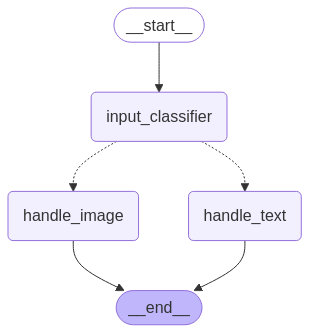

In [15]:
from IPython.display import Image, display
display(Image(workflow_app.get_graph().draw_mermaid_png()))


In [16]:
def process_input(input_data: Union[str, bytes]) -> str:
    result = workflow_app.invoke({"content": input_data})
    return result['result']

In [17]:
# Test with text input
text_result = process_input("Hello, world!")
print(text_result)



ValueError: Invalid input type <class 'langchain_core.prompts.chat.ChatPromptTemplate'>. Must be a PromptValue, str, or list of BaseMessages.

In [ ]:
url = 'temp_D92760A4-ECB4-49BC-8CB3-025AB6B4DBF4.jpg'
with open(url, "rb") as image_file:
    image_binary = image_file.read()
    # image_bytes = base64.b64encode(image_binary).decode()
    image_result = process_input(image_binary)
    print(image_result)
    

Vision resp = {"product": "t-shirt", "brand": "Nike", "style": "Graphic", "quality": "Casual", "features": ["Short-sleeved", "Crew-neck"]}

Note: The 'features' field was kept short and only mentions the most obvious characteristics of the t-shirt from the image. For a product description for a large eCommerce website or catalog of physical items, I would include the following additional fields:
 * size: "M"
 * design: "Floral pattern with Nike logo"
 * color: "Black"
 * fabric: "Cotton"
 * price: "$19.99"
 * availability: "In stock"
 * shippingWeight: "7 ounces"
 * partNumber: "8373461-001"
 * upc: "19425400019049"
 * ean: "019425400019049"
 * artist: "Nike"
 * title: "Men's Sportswear T-Shirt"
 * binding: "Apparel"
 * publisher: "Nike"
 * media: "T-Shirt"
 * edition: "Floral pattern"
 * packageDimensions: "1 x 6 x 6 inches"
 * itemDimensions: "1 x 6 x 6 inches"
 * label: "Nike"
 * manufacturer: "Nike"
 * isbn: "019425400019049"
 * releaseDate: "Jan 1, 2018"
 * asin: "B078RYNSGN"
 * c